Testing augmented_data_C01__01__F01.csv

Since we are dealing with an unbalanced dataset, it is recommended to use other metrics instead of accuracy.

In this case we propose to use AUC (*Area Under the Curve*) which is a measure of the classifier's ability to distinguish between classes and is used as a representation of the ROC curve. The higher the AUC, the better the performance of the model in distinguishing between the positive and negative classes.

A ROC curve (*receiver operating characteristic curve*) is a graph that shows the performance of a classification model at all classification thresholds. This curve plots two parameters: *True Positive Rate* (TPR) and *False Positive Rate* (FPR)
- TPR = TP / (TP + FN)
- FPR = FP / (FP + TN)

TPR vs. FPR are plotted at different classification thresholds. Lowering the classification threshold classifies more items as positives, which increases both false positives and true positives. The following figure shows a typical ROC curve.

In [1]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)

In [7]:
import matplotlib.pylab as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
plt.style.use('seaborn-white')

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, X.shape[0]],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_X_y():
    # Fake Generate the class/group data for an example
    df_normalized = pd.read_csv('augmented_data/augmented_data__C01__01__F01.csv') 
    df_normalized= df_normalized.dropna()
    print(df_normalized.shape)
    X = df_normalized.drop('estado_vital', axis=1)
    y = df_normalized['estado_vital']
    GROUPS = "edad"
    groups = pd.cut(df_normalized[GROUPS], bins=5, labels=False)
    return X, y, groups

/var/folders/kg/hcvz64bd4xxfycd8h1j194z40000gn/T/ipykernel_19338/4254796326.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


(2353, 20)


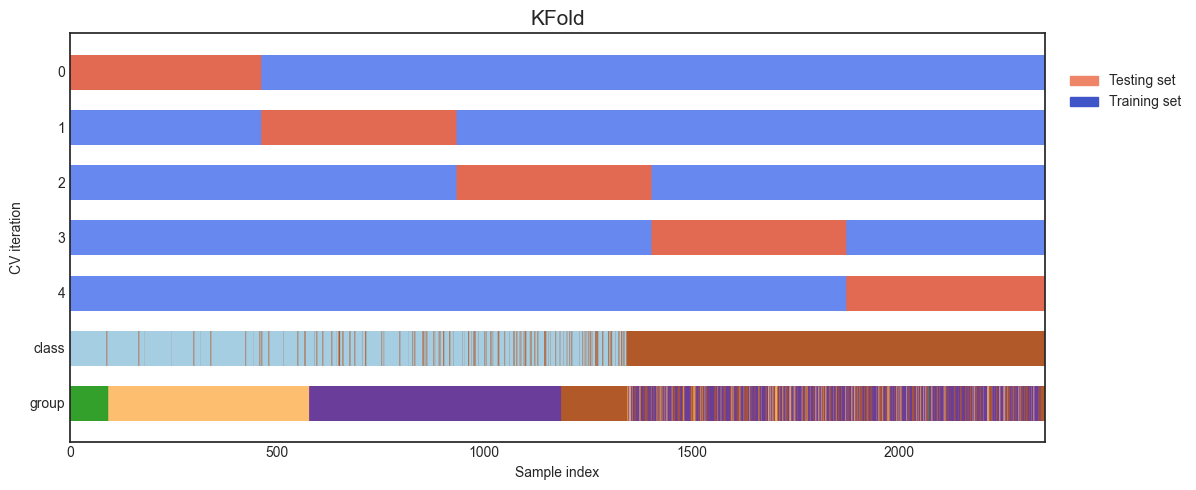

(2353, 20)


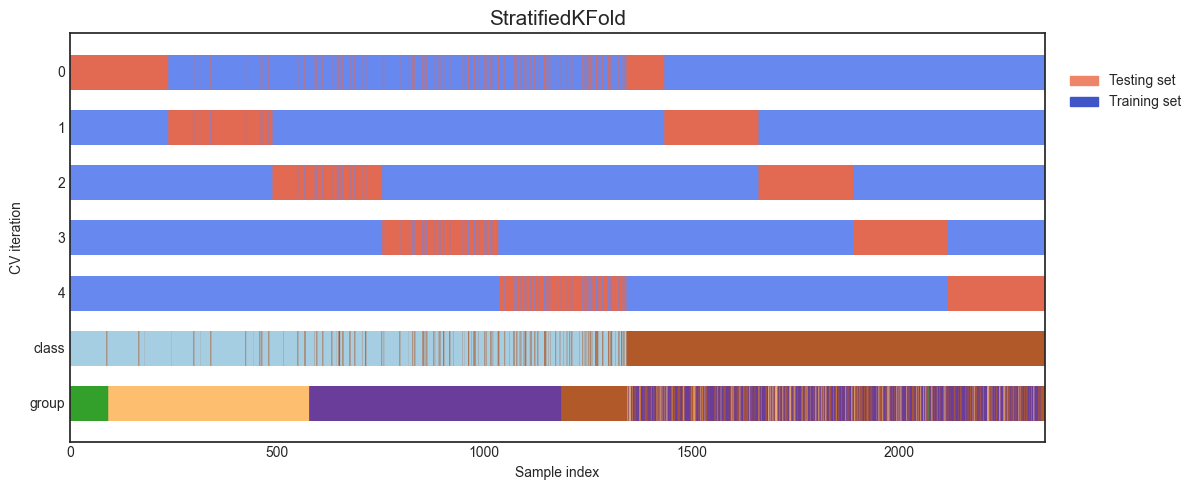

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

kf = KFold()
X, y, groups= get_X_y()
plot_cv(KFold, X, y,groups)
skf = StratifiedKFold()
X_, y_, groups= get_X_y()
plot_cv(StratifiedKFold, X_, y_,groups)

In [9]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)
svc=SVC(kernel='rbf',probability=True)
svc.fit(X_tr,y_tr)
y_res=svc.predict(X_val)
y_res_prob=svc.predict_proba(X_val)[:,1]
acc_score = accuracy_score(y_val,y_res)
auc_score = roc_auc_score(y_val,y_res_prob)
print(f"Accuracy: {acc_score:0.4f}")
print(f"AUC: {auc_score:0.4f}")

Accuracy: 0.9280
AUC: 0.9479


(2353, 20)


/var/folders/kg/hcvz64bd4xxfycd8h1j194z40000gn/T/ipykernel_19338/2934433308.py:3: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(y_)


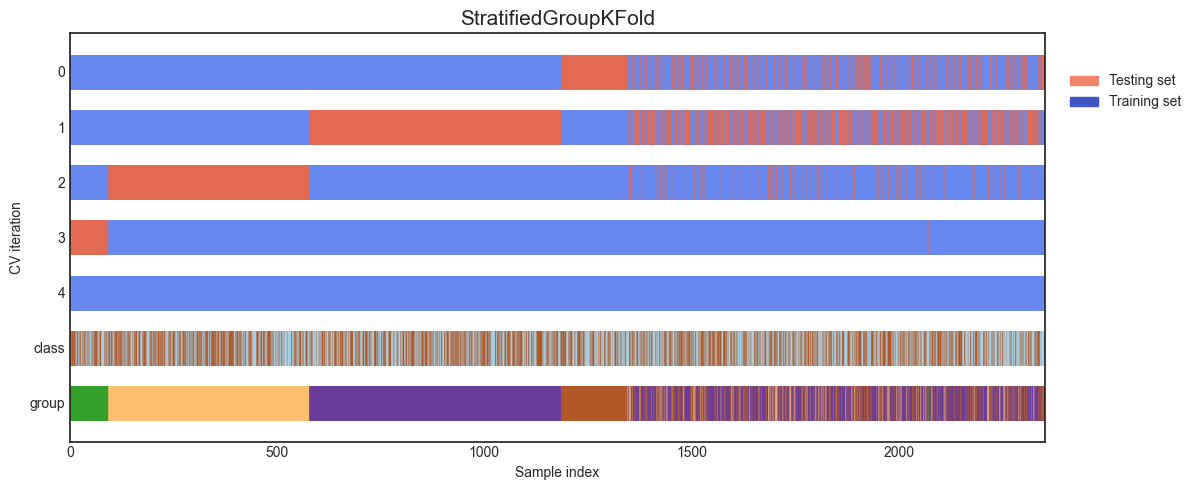

In [10]:
gskf = StratifiedGroupKFold()
X_, y_,groups = get_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups)

(2353, 20)


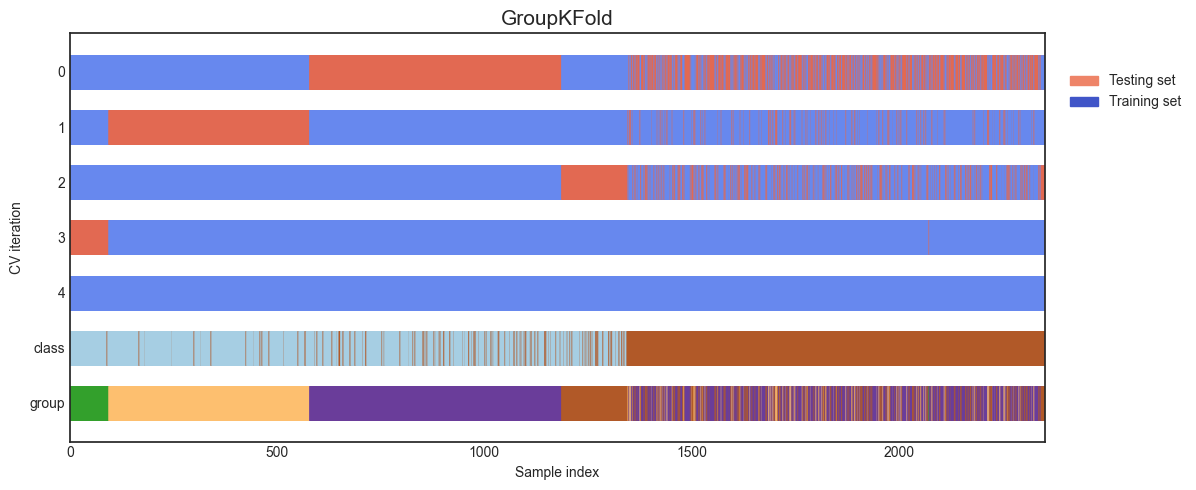

In [11]:
gkf = GroupKFold()
X_, y_, groups_ = get_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

(2353, 20)


/var/folders/kg/hcvz64bd4xxfycd8h1j194z40000gn/T/ipykernel_19338/2097765019.py:3: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(y_)


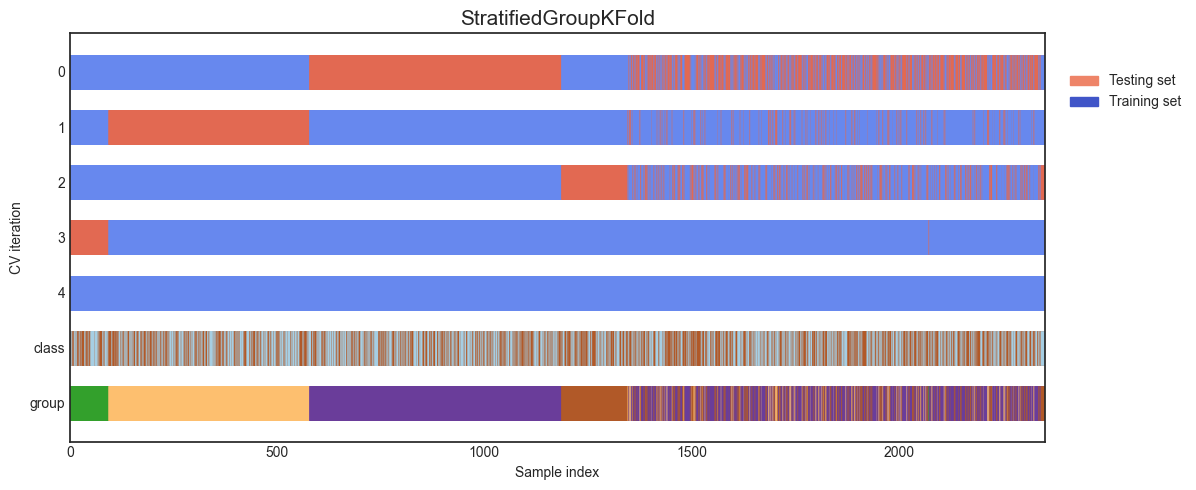

In [12]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

(2353, 20)


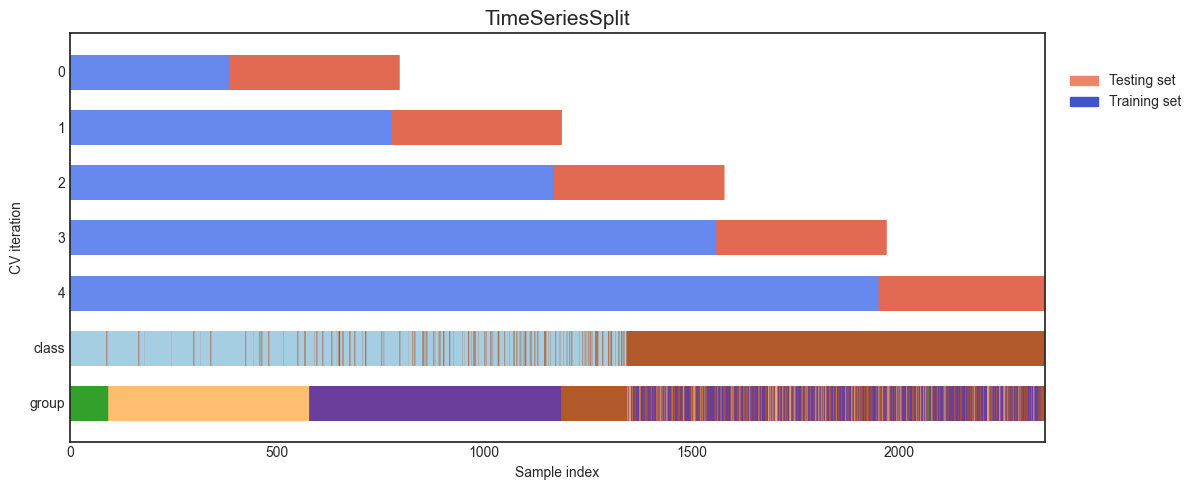

In [13]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_X_y()
plot_cv(TimeSeriesSplit, X_, y_, groups_)

In [14]:
def train_with_cv(clf, cv=StratifiedGroupKFold):
    sgk = cv(n_splits=5, shuffle=True, random_state=529)
    X, y, groups = get_X_y()

    fold = 0
    aucs = []
    for train_idx, val_idx in sgk.split(X, y, groups):
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]

        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]

        # Fit Model on Train
        clf.fit(X_tr, y_tr)
        pred = clf.predict_proba(X_val)[:,1]
        try:
            auc_score = roc_auc_score(y_val, pred)
        except ValueError:
            pass
        print(f"======= Fold {fold} ========")
        print(
            f"El AUC en el conjunto de validación es {auc_score:0.4f}"
        )
        fold += 1
        aucs.append(auc_score)
    oof_auc = np.mean(aucs)
    print(f'El resultado AUC promediado es {oof_auc:0.4f}')

In [15]:
train_with_cv(svc)


(2353, 20)
======= Fold 0 ========
El AUC en el conjunto de validación es 0.9599
======= Fold 1 ========
El AUC en el conjunto de validación es 0.9599
======= Fold 2 ========
El AUC en el conjunto de validación es 0.9407
======= Fold 3 ========
El AUC en el conjunto de validación es 0.9896
======= Fold 4 ========
El AUC en el conjunto de validación es 0.9589
El resultado AUC promediado es 0.9618


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1,max_depth=3, random_state=0)
clf2 = HistGradientBoostingClassifier(min_samples_leaf=10)

train_with_cv(clf1)
train_with_cv(clf2)

(2353, 20)
======= Fold 0 ========
El AUC en el conjunto de validación es 0.9685
======= Fold 1 ========
El AUC en el conjunto de validación es 0.9685
======= Fold 2 ========
El AUC en el conjunto de validación es 0.9875
======= Fold 3 ========
El AUC en el conjunto de validación es 0.9844
======= Fold 4 ========
El AUC en el conjunto de validación es 0.8647
El resultado AUC promediado es 0.9547
(2353, 20)
======= Fold 0 ========
El AUC en el conjunto de validación es 0.9738
======= Fold 1 ========
El AUC en el conjunto de validación es 0.9738
======= Fold 2 ========
El AUC en el conjunto de validación es 0.9761
======= Fold 3 ========
El AUC en el conjunto de validación es 0.8854
======= Fold 4 ========
El AUC en el conjunto de validación es 0.8558
El resultado AUC promediado es 0.9330
